In [11]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#IMPORT FILE AND FORMAT DATA
df = pd.read_csv('recipe_data.csv')
df.rename(columns={'Unnamed: 0':'Name'},inplace=True)

#GET nutrition data
nutrition_keys = list(json.loads(df['nutrition'][0].replace("'",'"')).keys())
nutrition_full = [json.loads(x.replace("'",'"').replace('g','')) for x in df['nutrition']]
for i in range(0,len(nutrition_keys)):
    df[nutrition_keys[i]] = [None]*len(df)
    for j in df.T:
        df.iloc[j][nutrition_keys[i]] = nutrition_full[j].get(nutrition_keys[i])
        
#format nutrition data as numbers      
for key in nutrition_keys:
    df[key] = df[key].apply(lambda x:float(x) if x!=None else float(0))
df.drop(columns=['dietary_req','nutrition'],inplace=True)
df['Calories'] = df['Calories'].apply(lambda x:int(x) if x!=None else x)

#get rid of messy html
def clean_cooking_method(x):
    return x.replace('<div class="">\n<ol class="recipeSteps">','') \
    .replace('</ol>','')[4:-1] \
    .replace('<i>','').replace('</i>','').replace('</li>','') \
    .replace('<li>','\n\n')
df['method'] = df['method'].apply(lambda x:clean_cooking_method(x))
df = df.rename(columns={'method':'Method'})

#remove invalid portion size data (eg 'enough for a few of your mates')
failed_ = df[df['Calories'].isna()]['Name']
failed2_ = df[(df['portions'] == [x for x in df['portions'] if 'enough' in x][0]) | \
                  (df['portions'] == [x for x in df['portions'] if 'enough' in x][1])]
excluding_blanks = list(set(df.index)-set(failed_.index)-set(failed2_.index))
df = df.iloc[excluding_blanks]

#convert portion size data to numbers
df['portions'] = df['portions'].apply(lambda x:int(x) if str(x).isdigit() else x)
df['portions'] = df['portions'].apply(lambda x:int(x.split('to')[0]) if (str(x).find('to') != -1)&(str(x).find('to')<3) else x)
df['portions'] = df['portions'].apply(lambda x:int(x.split('-')[0]) if (str(x).find('-') != -1)&(str(x).find('-')<3) else x)
df['portions'] = df['portions'].apply(lambda x:int(x.split('–')[0]) if (str(x).find('–') != -1)&(str(x).find('–')<3) else x)
df = df.iloc[[x for x,y in enumerate([type(x) for x in df['portions']]) if y==int]]

#calculate the combined calories
df['total_cals'] = df['Calories']*df['portions']


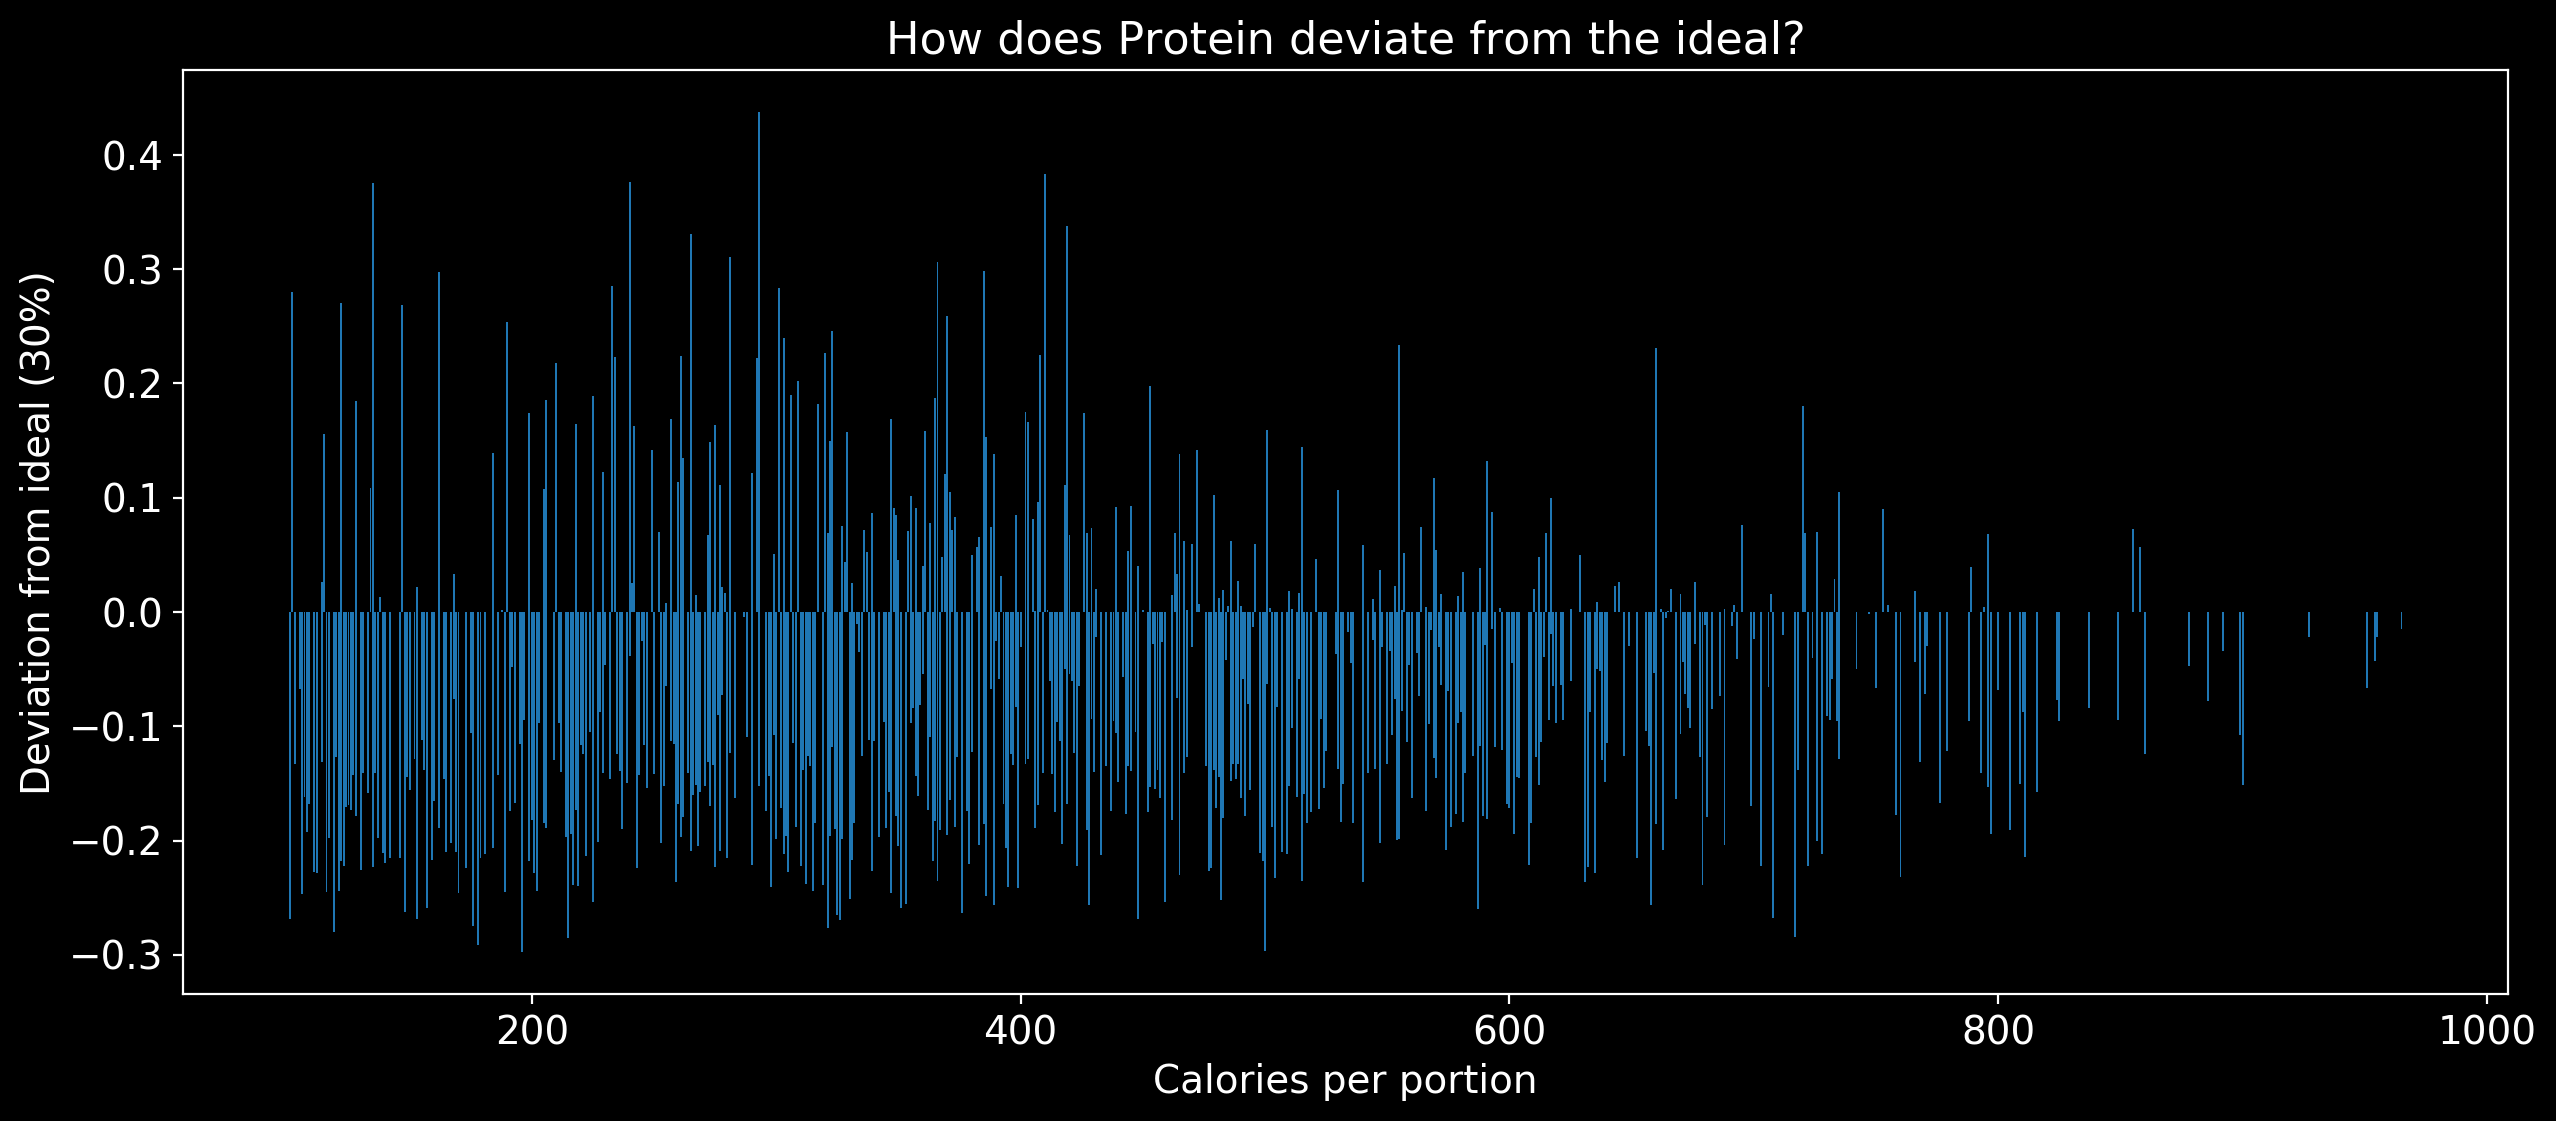

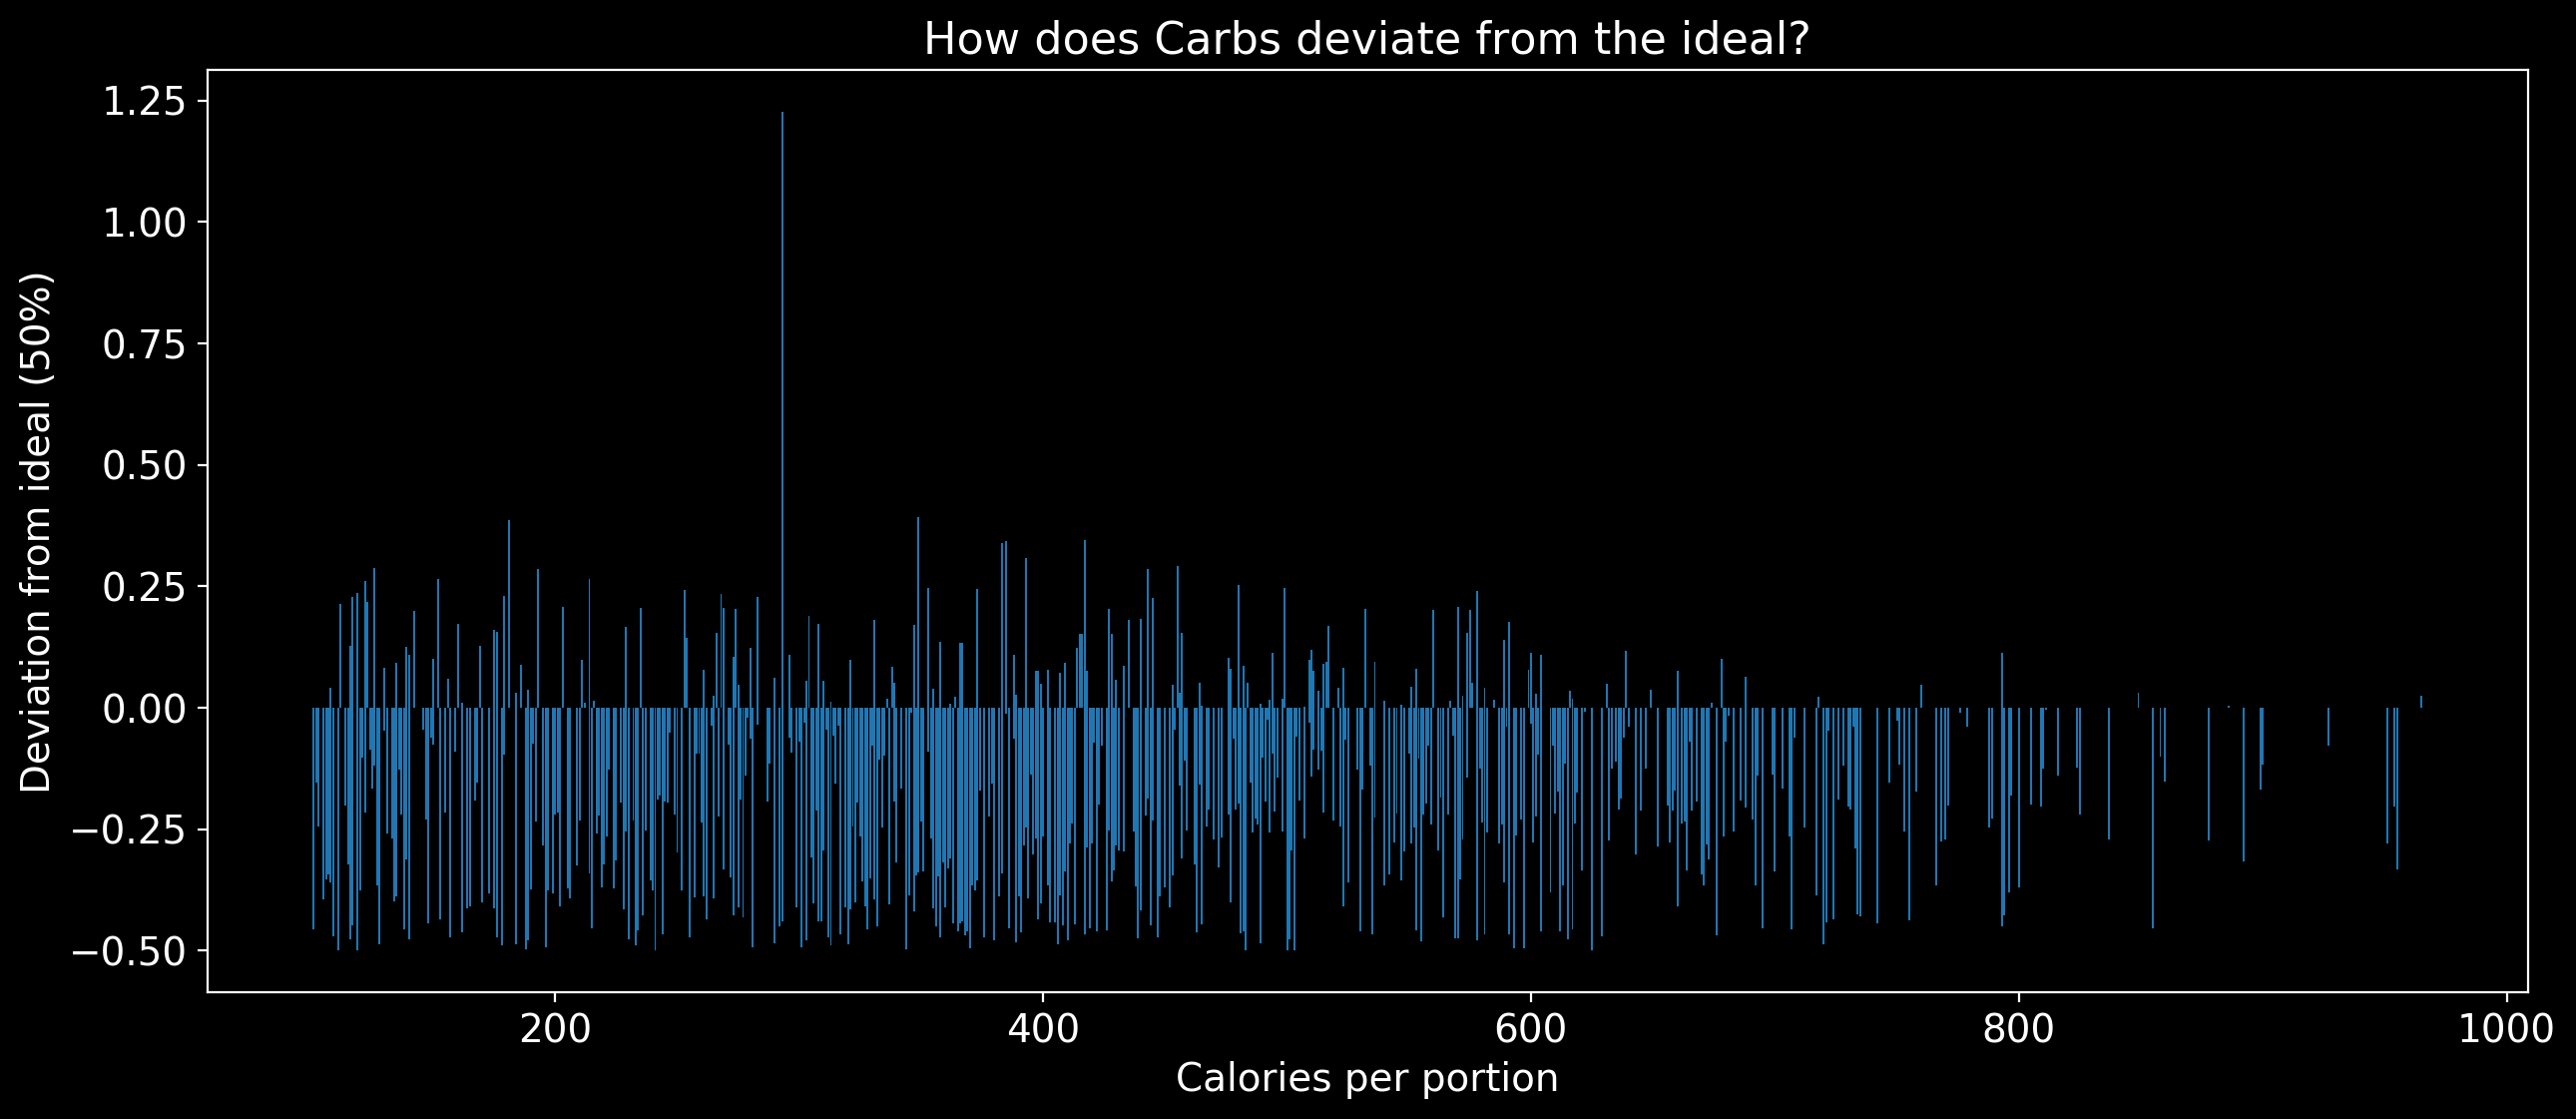

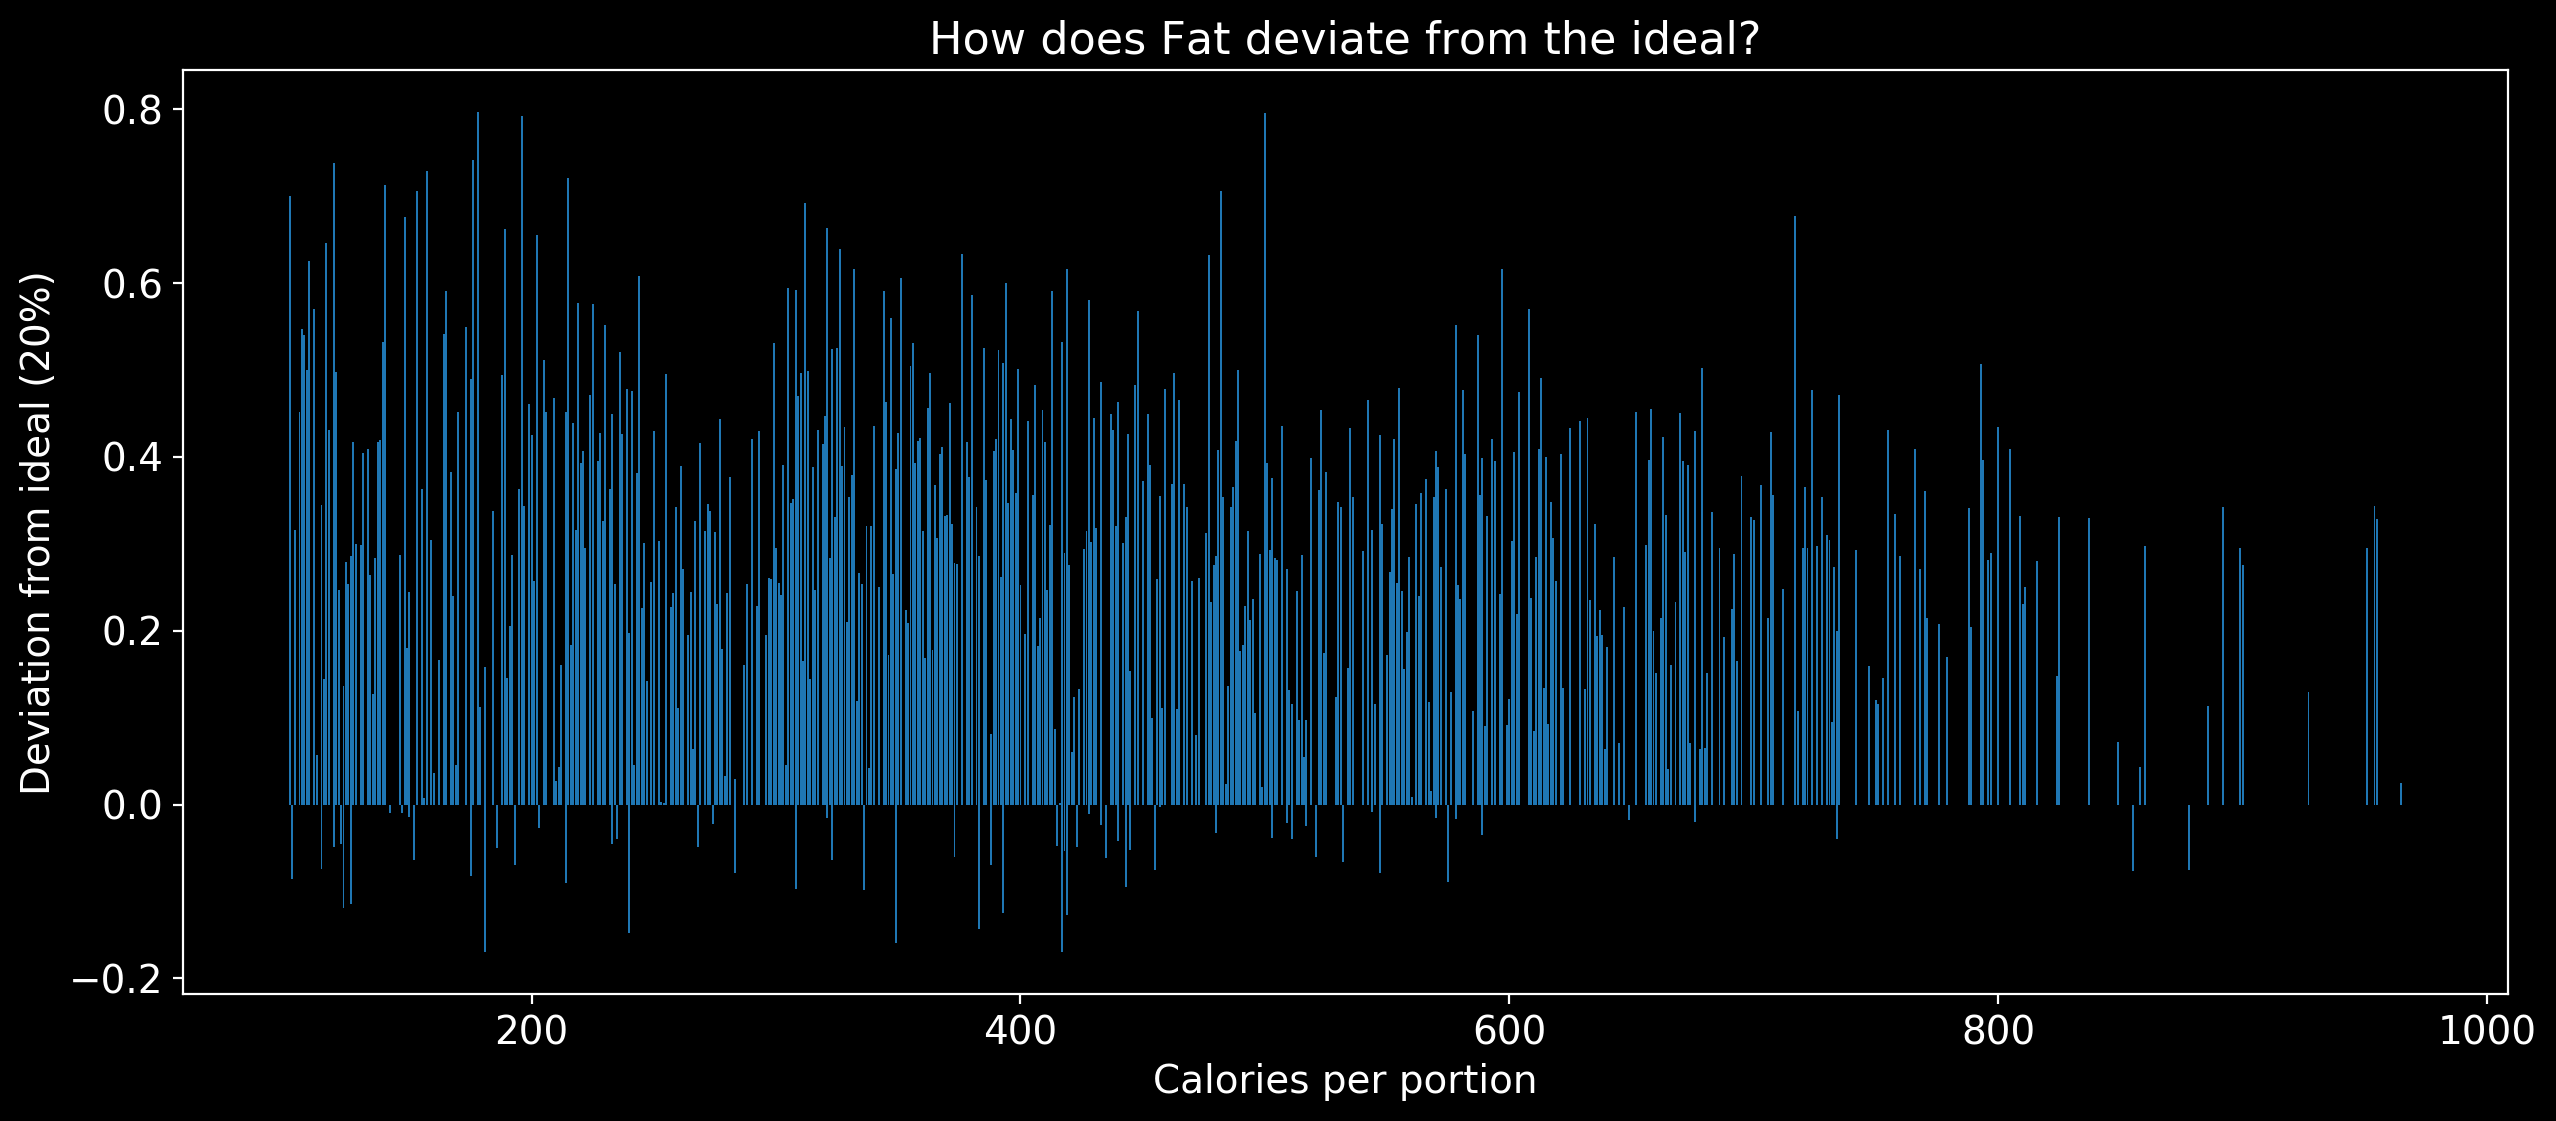

In [21]:
#Use nutrition data to work out which meals have the healthiest macro ratios
#protein distancefrom ideal
df['prot_pct'] = (df['Protein']*4)/df['Calories']
df["Protein_balance"] = df.prot_pct - 0.3 #30% CALS FROM PROTEIN IS CONSIDERED IDEAL
#carbs distancefrom ideal
df['carb_pct'] = (df['Carbs']*4)/df['Calories']
df['Carbs_balance'] = df.carb_pct - 0.5 #50% CALS FROM CARBS IS CONSIDERED IDEAL
#fats distancefrom ideal
df['fat_pct'] = (df['Fat']*9)/df['Calories']
df['Fat_balance'] = df.fat_pct - 0.2 #20% CALS FROM FAT IS CONSIDERED IDEAL

ideal = ['30%','50%','20%']
for each in ["Protein","Carbs","Fat"]:
    plt.figure(figsize=(15,6))
    nutrient = plt.bar(df[df["Calories"]>100]['Calories'],height=df[df["Calories"]>100][f"{each}_balance"],label=f'{each}')
    plt.title(f'How does {each} deviate from the ideal?',fontdict={'size':'16'})
    plt.xlabel('Calories per portion',fontdict={'size':'14'})
    plt.ylabel(f'Deviation from ideal ({ideal[["Protein","Carbs","Fat"].index(each)]})',fontdict={'size':'14'})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
   # plt.legend(handles=nutrient,bbox_to_anchor=(1,1),fontsize='large')
    plt.show()

# Most meals overdo the fat and underdo the carbs and protein.

In [40]:
#Print out the top performing
recipe_links = pd.read_csv("recipe_list.csv")[['recipe_name','recipe_link']]

#incase it gets deleted above:
#df["prot_balance"] = (df['Protein']*4)/df['Calories']-0.3 #30% CALS FROM PROTEIN IS CONSIDERED IDEAL
##carbs distancefrom ideal
#df['carb_balance'] = (df['Carbs']*4)/df['Calories']-0.5 #50% CALS FROM CARBS IS CONSIDERED IDEAL
##fats distancefrom ideal
#df['fat_balance'] = (df['Fat']*9)/df['Calories']-0.2 #20% CALS FROM FAT IS CONSIDERED IDEAL

tolerance = 10 #percent above or below allocated macros split for that nutrient

#remove meals that fall outside the tolerence window 
best = df[ \
   (df["Calories"]>300) \
   &(df["Protein_balance"]<(tolerance/100)) \
   &(-(tolerance/100)<df["Protein_balance"]) \
   &(df["Carbs_balance"]<(tolerance/100)) \
   &(-(tolerance/100)<df["Carbs_balance"]) \
   &(df["Fat_balance"]<(tolerance/100)) \
   &(-(tolerance/100)<df["Fat_balance"]) \
  ][["Protein_balance","Carbs_balance","Fat_balance"]]

top_macros = abs(best).loc[abs(best).mean(axis=1).sort_values(0).index].index

tmp = df.loc[top_macros]

print("\nFoods with ideal macro-nutrient ratios ~(50% Carbs, 30% Protein, 20% Fat)\n")
for i in range(len(df.loc[top_macros])):
    num = df.loc[top_macros].index[i]
    name = tmp.iloc[i]['Name']
    link = recipe_links[recipe_links['recipe_name']==name]['recipe_link'].values[0]
    portions = tmp.iloc[i]['portions']
    cals = tmp.iloc[i]['Calories']
    pro = tmp.iloc[i]['Protein']
    carb = tmp.iloc[i]['Carbs']
    fat = tmp.iloc[i]['Fat']
    propct = tmp.iloc[i].prot_pct
    carbpct = tmp.iloc[i].carb_pct
    fatpct = tmp.iloc[i].fat_pct
    takes = tmp.iloc[i]['cooking_time']
    print("\n",i+1,
          f"""{name}\n   Calories: {cals}\n   Protein: {pro}g Carbs:{carb}g Fat: {fat}g
\tP {propct:.0%}\t C {carbpct:.0%}\t F {fatpct:.0%}
    Takes:    {takes}\n   Serves:   {portions}\n   ref:{num}\n   {link}""")


Foods with ideal macro-nutrient ratios ~(50% Carbs, 30% Protein, 20% Fat)


 1 Roasted veg vindaloo with golden gnarly chicken skewers
   Calories: 544
   Protein: 37.7g Carbs:66.8g Fat: 11.6g
	P 28%	 C 49%	 F 19%
    Takes:    1H30M
   Serves:   6
   ref:780
   https://www.jamieoliver.com/recipes/chicken-recipes/roasted-veg-vindaloo-with-golden-gnarly-chicken-skewers/

 2 Grilled steak ratatouille & saffron rice
   Calories: 593
   Protein: 42.3g Carbs:71.3g Fat: 13.7g
	P 29%	 C 48%	 F 21%
    Takes:    15minutes
   Serves:   4
   ref:420
   https://www.jamieoliver.com/recipes/beef-recipes/grilled-steak-ratatouille-saffron-rice/

 3 Gorgeous Greek chicken
   Calories: 676
   Protein: 45.9g Carbs:84.0g Fat: 13.5g
	P 27%	 C 50%	 F 18%
    Takes:    30minutes
   Serves:   2
   ref:390
   https://www.jamieoliver.com/recipes/chicken-recipes/gorgeous-greek-chicken/

 4 Spicy 'nduja vongole
   Calories: 556
   Protein: 41.9g Carbs:62.5g Fat: 12.5g
	P 30%	 C 45%	 F 20%
    Takes:    15minute

In [42]:
tmp.head(2).T

,780,420
Name,Roasted veg vindaloo with golden gnarly chicke...,Grilled steak ratatouille & saffron rice
portions,6,4
cooking_time,1H30M,15minutes
ingredients,{'Preheat your oven to 200°C/400°F/gas 6. ': '...,"{'\n <div class=""nutrit..."
Method,Preheat your oven to 200°C/400°F/gas 6. \n\nSe...,"class="""">\n<strong>Ingredients out • Kettle b..."
Calories,544,593
Fat,11.6,13.7
Saturates,2.3,3.6
Protein,37.7,42.3
Carbs,66.8,71.3


In [43]:
tmp.iloc[1].ingredients

'{\'\\n                        <div class="nutrition-item" data-title="Calories" data-pos="-118" data-desc="Calories are just a unit of energy. If you eat more than you use you can gain weight, or lose it if you don\\\'t eat enough. How much you need depends on your weight, gender and how active you are, but it\\\'s around 2,000 a day.">\\n\\n                            <div class="nutrition-item-desc">\\n                                Calories                            </div>\\n                            <div class="nutrition-item-top">\\n                                593                            </div>\\n                            <div class="nutrition-item-bottom">\\n                                30%                            </div>\\n\\n                        </div>\\n                    \': \'\\n                        <div class="nutrition-item" data-title="Calories" data-pos="-118" data-desc="Calories are just a unit of energy. If you eat more than you use you can ga